# Bungee Jumping Drop

Shreya Chowdhary & Gail Romer


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

### Question
Your modeling question.
This question should avoid the four pitfalls discussed before Project 1.


### Model






(M) All three representations of your model: schematic diagram(worksheet), 
differential equations (Slope fn), 
and implementation in Python(to follow).
(M) An explanation of the decisions you made in creating your model. (E.g., What assumptions are baked in? Why did you choose those? Are they good or bad assumptions?)
These explanations should be thorough and belong in the essay portion of the text, not in code comments.


We used google to find the average weight for a human, approximated the diameter of a spherical human by curling in balls and measuring ourselves, found k value and mass of the bungee cord from the ModSimPy model. We assumed the bungee jumper is a sphere, as it is difficult to deturmine the drag of a bungee jumper because they may fall in many different orientations. This assumption is also based in reality, there are many videos of bungee jumpers who curl into a ball as they fall.

https://www.youtube.com/watch?v=g3pq1Pn_Mag


drag coefficient of a sphere: https://en.wikipedia.org/wiki/Drag_coefficient


In [3]:
def make_system(params):
    """Makes a system based on params input, including init state
        Calculates necessary values based on parameters"""
    
    init = State(h = params.init_height, v = 0 * m/s)
    
    area = np.pi * (params.diameter/2)**2
    
    mu = params.mass_bungee/(params.mass_human + params.mass_object)
    
    system = System(params, init = init, area = area, mu = mu)
    
    return system

In [4]:
def drag_force(v, system):
    """Calculates drag force from system variables and a given velocity"""
    
    unpack(system)

    return -np.sign(v) * rho * v**2 * C_d * area / 2

In [5]:
def whip_force(system, state):
    """Calculates whip force from system and state variables"""
    
    unpack(system)
    
    h, v = state
    
    a = np.sign(v)*(mu * (v**2)/2)/(mu*(bungee_rest_length + h) + 2*bungee_rest_length)
    
    return total_mass*a

In [6]:
def spring_force(h, system):
    """Calculates spring force from height difference and length of bungee cord"""
    
    unpack(system)
    
    return k*((init_height - h) - bungee_rest_length)

In [7]:
def slope_stage_14(state, t, system): #Stages 1 & 4 involve the same forces
    """Slope function determines change in height and change in velocity due to forces of drag, whip, and gravity
        Used in free-fall and free-fly stages"""
    
    unpack(system)
    h, v = state
    
    f_drag = drag_force(v, system)
    f_whip = whip_force(system, state)
    f_grav = (total_mass)*(-g)

    net_force = f_drag + f_whip + f_grav
#     Calculates acceleration from net force
    a = net_force/total_mass
    
    dhdt = v
    dvdt = a 
    
    return dhdt, dvdt

In [8]:
def slope_stage_23(state, t, system):
    """Slope function determines change in height and change in velocity due to forces of drag, spring, and gravity
        Used in stretch and return stages"""
    
    unpack(system)
    h, v = state
    
    f_drag = drag_force(v, system)
    f_spring = spring_force(h, system)
    f_grav = (total_mass)*(-g)
     
    net_force = f_drag + f_spring + f_grav
#     Calculates acceleration from net force
    a = net_force/total_mass
    
    dhdt = v
    dvdt = a
    
    return dhdt, dvdt

In [9]:
def plot_height(heights, stage):
    """Creates and labels plot of Height vs. Time"""
    plot(heights)
    title = "Height vs. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Height (m)")

In [10]:
def plot_velocity(velocities, stage):
    """Creates and labels plot of Velocity vs. Time"""
    plot(velocities)
    title = "Velocity vs. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Velocity (m/s)")

### Stage 1: Freefall

In [11]:
def free_fall_event(state, t, system):
    """Event function returns 0 when height difference is length of bungee cord"""
    
    unpack(system)
    
    h, v = state
    
    return bungee_rest_length - (init_height - h)

In [12]:
def free_fall(sys):
    """Finds Height and Velocity vs. Time for free fall stage, returns an updated system and the results from the stage"""
    
    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    
#     Solves for height and velocity over time for free-fall stage
    free_fall_results, details = run_ode_solver(system, slope_stage_14, events = free_fall_event, max_step = dt)
   
    h_final = get_last_value(free_fall_results.h) * m
    v_final = get_last_value(free_fall_results.v) * m/s
    
#     Plots data for free fall stage if p is true
    if p:
        plot_height(free_fall_results.h, "Free Fall Stage")
        plt.figure()
        plot_velocity(free_fall_results.v, "Free Fall Stage")
    
    
#     Creates new system and state from the end of free fall stage
    free_fall_state = State(h = h_final, v = v_final)  
    t_final = get_last_label(free_fall_results) * s
    system = System(system, init = free_fall_state, t_0 = t_final)
    
    return system, free_fall_results

### Stage 2: Stretch

In [13]:
def stretch_event(state, t, system):
    """Event function returns 0 when velocity is 0"""
    
    unpack(system)
    
    h, v = state
    
    return v

In [14]:
def stretch(sys):
    """Finds Height and Velocity vs. Time for stretch stage, returns an updated system and the results from the stage"""

    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)

#     Solves for height and velocity over time for stretch stage
    stretch_results, details = run_ode_solver(sys, slope_stage_23, events = stretch_event, max_step = dt)

    
    h_final = get_last_value(stretch_results.h) * m
    v_final = get_last_value(stretch_results.v) * m/s
    
#     Plots data for stretch stage if p is true
    if p:
        plot_height(stretch_results.h, "Stretch Stage")
        plt.figure()
        plot_velocity(stretch_results.v, "Stretch Stage")
    
#     Creates new system and state from the end of stretch stage
    stretch_state = State(h = h_final, v = v_final)
    t_final = get_last_label(stretch_results) * s
    system = System(sys, init = stretch_state, t_0 = t_final)
    
    return system, stretch_results

### Stage 3: Release
is this a necessary stage?

In [15]:
def return_event(state, t, system):
    """Event function returns 0 when height difference is length of bungee cord"""
    
    unpack(system)
    
    h, v = state
    
    return (init_height - h) - bungee_rest_length

In [16]:
def bungee_return(sys):
    """Finds Height and Velocity vs. Time for return stage, returns an updated system and the results from the stage"""

    unpack(sys)
    sys = System(sys,total_mass = mass_human)
    
#     Solves for height and velocity over time for return stage
    return_results, details = run_ode_solver(sys, slope_stage_23, events = return_event, max_step = dt)

    h_final = get_last_value(return_results.h) * m
    v_final = get_last_value(return_results.v) * m/s

#     Plots data for return stage if p is true
    if p:
        plot_height(return_results.h, "Return Stage")
        plt.figure()
        plot_velocity(return_results.v, "Return Stage")

#     Creates new system and state from the end of return stage
    return_state = State(h = h_final, v = v_final)
    t_final = get_last_label(return_results) * s
    system = System(sys, init = return_state, t_0 = t_final)
    
    return system, return_results

### Stage 5: Freefly

In [17]:
def free_fly_event(state,t,system):
    """Event function returns 0 when velocity is 0"""

    unpack(system)
    
    h, v = state
    
    return v

In [18]:
def free_fly(sys):
    """Finds Height and Velocity vs. Time for free-fly stage, returns an updated system and the results from the stage"""

    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    
#     Solves for height and velocity over time for free-fly stage
    free_fly_results, details = run_ode_solver(system, slope_stage_14, events = free_fly_event, max_step = dt)
    
    h_final = get_last_value(free_fly_results.h) * m
    v_final = get_last_value(free_fly_results.v) * m/s

#     Plots data for free-fly stage if p is true
    if p:
        plot_height(free_fly_results.h, "Free Fly Stage")
        plt.figure()
        plot_velocity(free_fly_results.v, "Free Fly Stage")
    
#     Creates new system and state from the end of free-fly stage
    free_fly_state = State(h = h_final, v = v_final)
    t_final = get_last_label(free_fly_results) * s
    system = System(system, init = free_fly_state, t_0 = t_final)
    
    return system, free_fly_results

### End Stage: Pass Height 0

In [19]:
params = Params(init_height = 220 * m,
                g = 9.8 * m/s**2,
                mass_human = 62 * kg,
                mass_object = 10 * kg,
                diameter = 0.8128 * m,        
                rho = 1.2 * kg/m**3,          
                k = 40 * N/m,               
                bungee_rest_length = 100 * m, 
                t_0 = 0 *s,
                t_end = 2000 * s,
                dt = .01*s, 
                C_d = 0.47,
                mass_bungee = 75 * kg,
                p=False);

In [20]:
def bungee_drop(mass, params):
    """Error function - returns 0 when final height equals initial height"""

    params = Params(params, mass_object = mass*kg)
    system = make_system(params)
    
#     Runs each stage, inputting system/state created from previous stage
    free_fall_system, free_fall_results= free_fall(system)
    stretch_system, stretch_results = stretch(free_fall_system)
    return_system, return_results = bungee_return(stretch_system)
    free_fly_system, free_fly_results= free_fly(return_system)

    return get_last_value(free_fly_results.h) * m - params.init_height

In [21]:
def sweep_mass(params):
    """Sweeps the mass of the object 
        produces a plot of mass vs difference between final and initial height"""

#     Creates a Timeseries and array for sweeping
    mass_series = TimeSeries()
    mass_array = linrange(20,30,1)
    print(mass_array)

#     Sweeps mass and calculates difference between final and initial height
    for mass in mass_array:
        m = mass
        results = bungee_drop(m,params)
        mass_series[mass] = results
#     Plots swept data
    plot(mass_series)

[20 21 22 23 24 25 26 27 28 29]


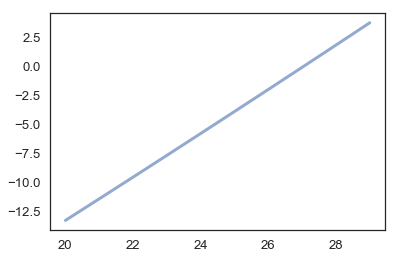

In [22]:
sweep_mass(params)

In [23]:
# Solves for mass that makes the difference between final and initial height equal to 0
mass = fsolve(bungee_drop, 35, params)[0]

27.05408378821303

In [24]:
# Checks the mass produced by fsolve 
bungee_drop(mass, params)

<Quantity(2.8990143619012088e-12, 'meter')>

220.0000000000029


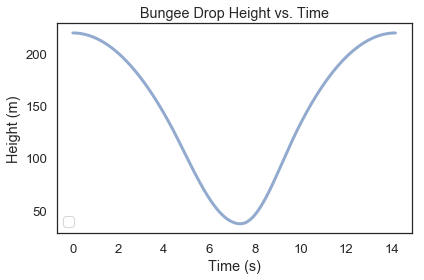

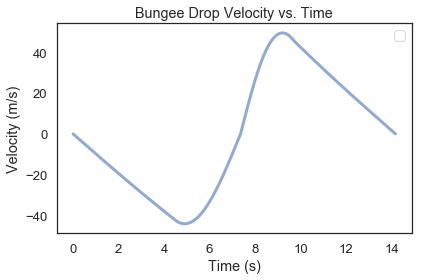

In [25]:
def plot_final(mass, params):
    """Runs, concatinates, and plots results from the four stages based on mass found by fsolve"""

    params = Params(params, mass_object = mass*kg)
    system = make_system(params)

#     Runs all stages 
    free_fall_system, free_fall_results= free_fall(system)
    stretch_system, stretch_results = stretch(free_fall_system)
    return_system, return_results = bungee_return(stretch_system)
    free_fly_system, free_fly_results= free_fly(return_system)
    
#     Concatinates results into one array
    frames = [free_fall_results, stretch_results, return_results, free_fly_results]
    result = pd.concat(frames)

#     Plots and labels figure of Height vs. Time
    plot(result.h)
    decorate(title = "Bungee Drop Height vs. Time", ylabel = "Height (m)", xlabel = "Time (s)", legend = mass)

#     Plots and labels New figure of Velocity vs. Time
    plt.figure()
    plot(result.v)
    decorate(title = "Bungee Drop Velocity vs. Time", ylabel = "Velocity (m/s)", xlabel = "Time (s)", legend = mass)

#     Prints last value of height
    print(get_last_value(result.h))
plot_final(mass,params)


In [26]:
print(mass)

27.05408378821303


### Results
(R) The well-labeled figures you created to show the output of your simulation.
(R) The answer to your modeling question (weight of object).
(R or I) Text explaining how the figure showing your output leads you to the answer of your question.
This can also include annotations on the figure.


### Interpretation
(I) In the Interpretation section, acknowledgment of any significant failings of the model accompanied by explanation of what measures were taken to address the problem and what additional steps would be taken next if the project were to continue.
Significant failings might include (but are not limited to) a model that does not answer the question, a model that has so many limitations and assumptions that the output is meaningless, or a model that does not go beyond simple statistical modeling (e.g., showing correlations between variables).
(I) A few sentences in the Interpretation section explaining the role of iteration in your modeling process.

Human as sphere
no rotation
no delta drag w/drop of object

started with only spring force and gravity with no change in mass
tested each stage in isolated batches before stringing them together
once bugs were worked out we itterativly added the drag force, change in mass, and whip force to the model



According to https://www.bluebulbprojects.com/measureofthings/results.php?comp=weight&unit=kgms&amt=27&sort=pr&p=2 the 62kg bungee jumper should be carrying either 4 bowling balls, 5 gallons of paint, 6 cats, 9.5 bricks, 12 chihuahuas, 20 human brains, or 45 basketballs (some of which would be unreasonable because they would effect drag). 